In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd


In [9]:
def read_positions(N,box,T,Dt,noise,v0):
    filename = f'particle_positions_N_particles_{N}_box_{box}_T_{T}_Dt_{Dt}_noise_{noise}_v0_{v0}.dat'
    data= np.loadtxt(filename)
    X = data[:,0]
    Y = data[:,1]
    Steps = len(X) //N 
    X = np.reshape(X,(Steps,N))
    Y = np.reshape(Y,(Steps,N))
    return X,Y


# Movie

In [53]:
import os 

N = 5000
Time = 150
BOX_SIZE = 10
Dt=0.1
noise=0.1
v0=1
X,Y = read_positions(N,BOX_SIZE,Time,Dt,noise,v0)



In [24]:

fig, ax1 = plt.subplots(figsize=(5,5))  

max_x = X.max()
max_y = Y.max()
# x,y = [], []
file_to_save = f'positions_frames_N_particles_{N}_box_{BOX_SIZE}_T_{Time}_Dt_{Dt}_noise_{noise}_v0_{v0}'
os.makedirs(file_to_save,exist_ok=True)
for time in range(Time):
    ax1.clear()
    Xnow = X[time]
    Ynow = Y[time]
    # Xnext = X[time+1]
    # Ynext = Y[time+1]
    # Xp_now = Xp[time]
    # Yp_now = Yp[time]
    for posx, posy in zip(Xnow, Ynow):
        # lx= abs(-dx + posx)
        # ly = abs(-dy + posy)
        ax1.add_patch(plt.Circle((posx, posy), radius=0.15, fill=True,color='red'))
        # if lx >= BOX_SIZE/2 or ly >= BOX_SIZE/2:
        #     ax1.plot(posx,posy,lw=0,marker='o',ms=0.01)
        # else:
        #     ax1.plot(np.array([posx,dx]),np.array([posy,dy]))
        
        
        ax1.set_title(f'frame {time}',fontsize=12,loc='left')
        
    ax1.set_xlim(0,BOX_SIZE)
    ax1.set_ylim(0,BOX_SIZE)
    # ax1.set_xticks([0,BOX_SIZE//2, BOX_SIZE])
    # ax1.set_yticks([0,BOX_SIZE//2, BOX_SIZE])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    # ax1.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    
    plt.savefig(f"{file_to_save}/positions_{time:03d}.png",dpi=200)
plt.close()

In [54]:
data = []
for time_step in range(Time):
    for particle_id in range(N):
        data.append({
            'particle': particle_id + 1,  # Particle ID (1-indexed)
            'x': X[time_step, particle_id],
            'y': Y[time_step, particle_id],
            'time step': time_step + 1
        })
        
dataframe = pd.DataFrame(data)
dataframe
dataframe.to_csv(f'N_particles_{N}_box_{BOX_SIZE}_T_{Time}_Dt_{Dt}_noise_{noise}_v0_{v0}.csv')

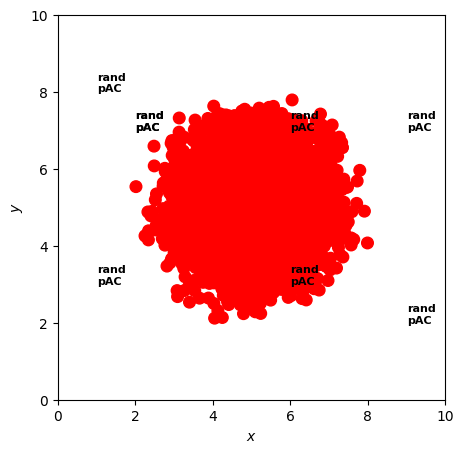

In [55]:
import random
import statsmodels.api as sm
x_max_px = y_max_px = BOX_SIZE
Xnow = X[38]
Ynow = Y[38]
fig, ax = plt.subplots(figsize=(5,5))
pos_random_ACs = []
for i in range(8):
    x = random.randrange(0,x_max_px)
    y = random.randrange(0,y_max_px)
        
    pos_random_ACs.append([x,y])

for pos in pos_random_ACs:
    ax.annotate('rand\npAC',xy=(pos[0],pos[1]),color='black',weight='bold',size=8)
color = plt.cm.rainbow(np.linspace(2, 3, N))
i=0 
for posx, posy in zip(Xnow, Ynow):

    ax.add_patch(plt.Circle((posx, posy), radius=0.15, fill=True,color=color[i]))
    i+=1
# ax.plot([1,2],[3,4])
ax.set_xlim(0,BOX_SIZE)
ax.set_ylim(0,BOX_SIZE)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.savefig(f'pAC/loc_pACs_N_{N}.png',dpi=200)
plt.show()

In [56]:
ids = np.arange(1,N).astype('int32')
for id in ids:
        traj= dataframe[dataframe['particle'] == id].sort_values('time step')
            
            # file_xy = np.loadtxt(f'/media/janne/Transcend/bacteria/apoptotic_cells/time_x_y/time_x_y_id_{id}.dat') #time x y 
        file_name_min = f'pAC/id_{id}_dist_ALL_PAC.dat'
        time = traj['time step'].values
        x = traj['x'].values
        y = traj['y'].values
        min_dist_list = []
        time_cut = time[:]
        for t in range(150):
            dist_at_time_t=[]
            for cell in pos_random_ACs:
                # print(id,x[t],cell)
                dist_to_cell = np.sqrt((cell[0] - x[t])**2 + (cell[1] - y[t])**2)
                dist_at_time_t.append(dist_to_cell)
            
            
            min_dist_to_apoptotic = min(dist_at_time_t)
            min_dist_list.append(min_dist_to_apoptotic)
        np.savetxt(file_name_min,np.c_[time_cut,min_dist_list],fmt='%.4f')
            # with open(file_name_min, 'a') as kk:

            #     kk.write(f'{time[t]} {min_dist_to_apoptotic:.3f}\n')

        

def dist_to_phantom_calc(ids): 
        
    average_m_list = []  
    for id in ids:
        file_name_min = f'pAC/id_{id}_dist_ALL_PAC.dat'
        # file_name_min_deriv = f'/media/janne/Transcend/bacteria/apoptotic_cells/distance_nearest_apop_cell/phantom_AC/id_{id}_dist.dat'
        file_min = np.loadtxt(file_name_min,usecols=(0,1))
        time = file_min[:,0]
        
        dist = file_min[:,1]
        lowess = sm.nonparametric.lowess
            


        traj= lowess(dist,time,frac=0.09,it=1, return_sorted=True)
        deriv_from_smoothed = np.diff(traj[:,1])/np.diff(time)
        average_m = np.average(deriv_from_smoothed)
        average_m_list.append(average_m)

    return average_m_list

data = dist_to_phantom_calc(ids)

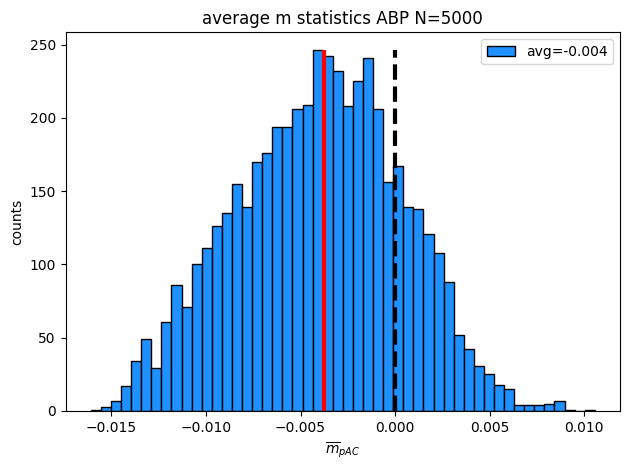

In [57]:

bins=50
fig, ax2=plt.subplots()
data_2,bins_2=np.histogram(data,bins=bins)
binscenters_2=0.5*(bins_2[1:]+bins_2[:-1])
Exp_2 = np.sum(binscenters_2*data_2)/np.sum(data_2)
ax2.bar(bins_2[:-1],data_2,width=bins_2[1]-bins_2[0],color='dodgerblue',label=f'avg={Exp_2:.3f}' ,linewidth=1,edgecolor='black')
ax2.vlines(0,0,max(data_2),color='black',lw=3,ls='--')
ax2.vlines(Exp_2,0,max(data_2),color='red',lw=3,ls='-')

ax2.set_xlabel(r'$\overline{m}_{pAC}$')
ax2.set_ylabel('counts')
ax2.set_title(f'average m statistics ABP N={N}')
ax2.legend()
plt.tight_layout()
plt.savefig(f'pAC/pAC_stat_ABP_particles_N_particles_{N}_box_{BOX_SIZE}_T_{Time}_Dt_{Dt}_noise_{noise}_v0_{v0}.png',dpi=200)
plt.show()